# XAI_CNN

XAI 기능을 수행하는 GradCAM을
CNN 모델인 Xception에 적용해보겠다. - 이종은

In [6]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [1]:
from tensorflow.keras.applications import xception

In [2]:
model = xception.Xception(weights="imagenet")
model.summary()

91889664/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [8]:
imagePath = "waterOuzel.jpg"

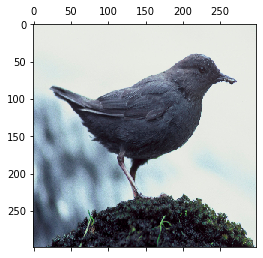

In [11]:
img = image.load_img(imagePath, target_size=(299,299))
plt.matshow(img)

In [27]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = xception.preprocess_input(x)
# 신경망 입력 형태로 변환

In [14]:
preds = model.predict(x)
print("Top-5 prediction", xception.decode_predictions(preds, top=5)[0])

40960/35363 [==================================] - 0s 0us/step
Top-5 prediction [('n01601694', 'water_ouzel', 0.92283916), ('n01534433', 'junco', 0.0033709374), ('n01580077', 'jay', 0.0032955294), ('n02018207', 'American_coot', 0.0026270056), ('n02017213', 'European_gallinule', 0.0016352675)]


### 예측 결과 water_ouzel이 가장 높게 나왔으며, 이는 옳은 예측이다.

In [28]:
lastConvLayer = model.get_layer("block14_sepconv2_act")
model1 = keras.Model(model.inputs, lastConvLayer.output)

In [29]:
input2 = keras.Input(shape=lastConvLayer.output.shape[1:])
x2 = model.get_layer("avg_pool")(input2)
x2 = model.get_layer("predictions")(x2)
model2 = keras.Model(input2, x2)

In [30]:
with tf.GradientTape() as tape:
    output1 = model1(x)
    tape.watch(output1)
    preds = model2(output1)
    classId = tf.argmax(preds[0])
    output2 = preds[:, classId]

In [31]:
grads = tape.gradient(output2,output1) # gradient 계산
pooledGrads = tf.reduce_mean(grads,axis=(0,1,2))

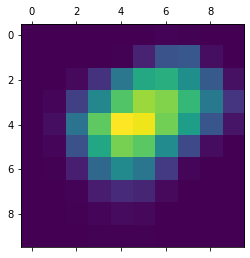

In [32]:
output1 = output1.numpy()[0]
pooledGrads = pooledGrads.numpy()
for i in range(pooledGrads.shape[-1]):
    output1[:,:,i] *= pooledGrads[i]
# heatmap 구하기
heatmap = np.mean(output1, axis=-1)
# heatmap 정규화
heatmap=np.maximum(heatmap,0)/np.max(heatmap)
plt.matshow(heatmap)

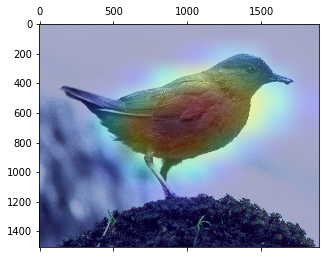

In [33]:
# original image에 heatmap 덧씌우기
img=image.load_img(imagePath)
img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap)
jet=cm.get_cmap("jet")
color=jet(np.arange(256))[:,:3]
color_heatmap=color[heatmap]
color_heatmap=keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap=color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap=keras.preprocessing.image.img_to_array(color_heatmap)
overlay_img=color_heatmap*0.4+img
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

### 몸통 부분이 빨갛게 표시됐음을 확인할 수 있다.
### 시각화 수준의 설명 기능이 수행됐음을 확인했다.